In [2]:
import os
import shutil
import matplotlib.colors as mcolors
import random
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import numpy as np
import pydicom
import cv2

from tqdm import tqdm
from PIL import Image
from duke_dbt_data import dcmread_image
from typing import AnyStr, BinaryIO, Dict, List, NamedTuple, Optional, Union
from skimage.transform import resize
from skimage.exposure import rescale_intensity
from skimage.metrics import structural_similarity as ssim

# Métodos

In [2]:
def combinar_imagenes(imagenes_seleccionadas):
    # Asegurarse de que tenemos al menos una imagen
    if len(imagenes_seleccionadas) > 0:
        # Convertir imagenes_seleccionadas a una matriz numpy
        imagenes_seleccionadas = np.array(imagenes_seleccionadas)
        
        # Verificar que tengamos al menos 4 imágenes seleccionadas
        if imagenes_seleccionadas.shape[0] >= 4:
            # Crear un array para almacenar las imágenes reorganizadas
            imagenes_reorganizadas = np.zeros((1440,1440), dtype=np.uint8)
            
            # Iterar sobre cada imagen y colocarla en su posición deseada
            for i, img in enumerate(imagenes_seleccionadas[:4]):
                if i == 0:  # Parte superior izquierda
                    imagenes_reorganizadas[:720, :720] = img.astype(np.uint8)
                elif i == 1:  # Parte superior derecha
                    imagenes_reorganizadas[:720, 720:] = img.astype(np.uint8)
                elif i == 2:  # Parte inferior izquierda
                    imagenes_reorganizadas[720:, :720] = img.astype(np.uint8)
                elif i == 3:  # Parte inferior derecha
                    imagenes_reorganizadas[720:, 720:] = img.astype(np.uint8)
    
            return imagenes_reorganizadas
        else:
            print("Error: Se requieren al menos 4 imágenes seleccionadas.")
    else:
        print("Error: No se han seleccionado imágenes.")
    print(imagenes_reorganizadas.shape)
    
# Ejemplo de uso
# Suponiendo que tienes una lista de imágenes llamada imagenes_seleccionadas
# Llamamos a la función con esta lista de imágenes
# resultado = combinar_imagenes(imagenes_seleccionadas)

def seleccionar_imagenes(columna, filas_mismo_study_uid, boxes_df, pathNumpy):
    # Inicializar las imágenes seleccionadas con imágenes en negro de tamaño 720x720
    imagenes_seleccionadas = np.zeros((4, 720, 720), dtype=np.uint8)
    for i, row in filas_mismo_study_uid.iterrows():
        PatientID = row["PatientID"]
        StudyUID = row["StudyUID"]
        view = row["View"]
        nombre = f"{view}-{i}.npy"
        ruta = os.path.join(f"{pathNumpy}{columna}", nombre)
        #print(ruta)
        if os.path.exists(ruta):
            imagen_cargada = np.load(ruta)
            #print(columna)
            if columna == "/Normal" or columna == "/Actionable":
                longitud_primera_dimension = imagen_cargada.shape[0]
                indice_slice = int(longitud_primera_dimension * 0.40898656) # Es la media de donde se encuentran los canceres
            else:
                # Usando indexación booleana para filtrar el DataFrame
                fila_deseada = boxes_df[(boxes_df['PatientID'] == PatientID) & (boxes_df['StudyUID'] == StudyUID)]
                fila_deseada = fila_deseada.iloc[0]
                indice_slice = fila_deseada['Slice']

            #print("Indice Slice:",indice_slice)
            # Verificar si el índice es válido
            if indice_slice < imagen_cargada.shape[0]:
                if view == 'lcc':
                    imagenes_seleccionadas[0] = imagen_cargada[indice_slice, :, :, 1]
                elif view == 'rcc':
                    imagenes_seleccionadas[1] = imagen_cargada[indice_slice, :, :, 1]
                elif view == 'lmlo':
                    imagenes_seleccionadas[2] = imagen_cargada[indice_slice, :, :, 1]
                elif view == 'rmlo':
                    imagenes_seleccionadas[3] = imagen_cargada[indice_slice, :, :, 1]
                
    return imagenes_seleccionadas

def obtener_columna(fila):
    # Verificar el valor de cada columna y asignar el nombre correspondiente a las variables
    columna = None
    if fila["Normal"] == 1:
        columna = "/Normal"
    elif fila["Actionable"] == 1:
        columna = "/Actionable"
    elif fila["Benign"] == 1:
        columna = "/Benign"
    elif fila["Cancer"] == 1:
        columna = "/Cancer"
    return columna

In [56]:
pathdfTest = "D:/Codigo/Datos/InfTest/BCS-DBT-boxes-test-v2-PHASE-2-Jan-2024.csv"
pathdfVal = "D:/Codigo/Datos/InfValidation/boxes-validation.csv"
pathdfTrain = "D:/Codigo/Datos/InfTraining/boxes-train.csv"

merged_dfTest = pd.read_csv(pathdfTest)
merged_dfVal = pd.read_csv(pathdfVal)
merged_dfTrain = pd.read_csv(pathdfTrain)

# Unir los DataFrames
merged_df = pd.concat([merged_dfTest, merged_dfVal, merged_dfTrain])

# Asegúrate de que las columnas 'Slice' y 'VolumeSlices' contienen valores numéricos
merged_df['Slice'] = pd.to_numeric(merged_df['Slice'])
merged_df['VolumeSlices'] = pd.to_numeric(merged_df['VolumeSlices'])

# Calcular los valores porcentuales de la columna 'Slice' con respecto a 'VolumeSlices'
merged_df['Porcentaje'] = (merged_df['Slice'] / merged_df['VolumeSlices']) * 100

# Calcular la media de los valores porcentuales
media_porcentaje = merged_df['Porcentaje'].mean()

print("La media de valores porcentuales de la columna 'Slice' con respecto a 'VolumeSlices' es:", media_porcentaje)

La media de valores porcentuales de la columna 'Slice' con respecto a 'VolumeSlices' es: 40.898655837115925


In [ ]:
#Prueba construccion imagen
patgdfBoxes = "D:/Codigo/Datos/InfValidation/boxes-validation.csv"
pathdf = "D:/Codigo/Datos/InfValidation/merged_dfValidation_serialized.pickle"
pathNumpy = "D:/Numpys/imagenesValCompletas"
merged_df = pd.read_pickle(pathdf)
df_boxes = pd.read_csv(patgdfBoxes)
index = 51
primera_fila = merged_df.iloc[index]  #301 tiene una imagen

# Encuentra todas las filas con el mismo 'StudyUID' que la primera fila
filas_mismo_study_uid = merged_df[merged_df['StudyUID'] == primera_fila['StudyUID']]

print(filas_mismo_study_uid)
# Inicializa la imagen final como una matriz de ceros

# Obtener la columna correspondiente Normal, Actionable, Cancer o Benign
columna = obtener_columna(filas_mismo_study_uid.iloc[0])

# Seleccionar las imágenes correspondientes a esta fila
imagenes_seleccionada = seleccionar_imagenes(columna, filas_mismo_study_uid, df_boxes, pathNumpy)
print(f"imagenes_seleccionadas: {imagenes_seleccionada.shape}")

# Convertir la lista de resultados en un numpy array
#resultados_array = np.array(imagenes_seleccionadas)

# # Guardar el numpy array
#np.save("resultados.npy", resultados_array)

# for i in range(10):
#     resultado = combinar_imagenes(imagenes_seleccionadas[i])
#     print(resultado.shape)# Guarda la imagen final
#     cv2.imwrite(f"resultados/image_{i}.png", resultado)
#     # Guardar la imagen final como un archivo Numpy serializado
    #np.save(f"final_image_{index}.npy", resultado)

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
# Iterar sobre las imágenes y mostrarlas en los ejes correspondientes
for i, ax in enumerate(axs.flatten()):
    ax.imshow(imagenes_seleccionada[i])
    ax.set_title(f'Imagen {i+1}')  # Añadir título a cada imagen
    ax.axis('off')  # Desactivar los ejes

plt.tight_layout()  # Ajustar el espaciado entre subgráficos
plt.show()

# Separar en cáncer, benigno, actionable y normal

In [5]:
# Validation
patgdfBoxes = "D:/Codigo/Datos/InfValidation/boxes-validation.csv"
pathdf = "D:/Codigo/Datos/InfValidation/merged_dfValidation_serialized.pickle"

pathNumpySave = "D:/Numpys/DBT Totales/TotalArray"
pathNumpy =     "D:/Numpys/DBT Totales/imagenesValCompletas"

# Cargar el DataFrame desde un archivo pickle serializado
merged_df = pd.read_pickle(pathdf)
df_boxes = pd.read_csv(patgdfBoxes)

for index, row in tqdm(merged_df.iterrows(), total=merged_df.shape[0], desc="Cargando imagen"):
    filas_mismo_study_uid = merged_df[merged_df['StudyUID'] == row['StudyUID']]
    
    if not filas_mismo_study_uid.empty:
        merged_df.drop(filas_mismo_study_uid.index, inplace=True)
        
        columna = obtener_columna(filas_mismo_study_uid.iloc[0])
        imagenes_seleccionadas = seleccionar_imagenes(columna, filas_mismo_study_uid, df_boxes, pathNumpy)
        
        nombre = f"{filas_mismo_study_uid.iloc[0]['StudyUID']}_{filas_mismo_study_uid.iloc[0]['PatientID']}"
        ruta_archivo = os.path.join(f"{pathNumpySave}{columna}", nombre)
        if os.path.exists(ruta_archivo):
            print(f"El archivo {ruta_archivo} ya existe.")
        np.save(ruta_archivo, imagenes_seleccionadas)

Cargando imagen: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1163/1163 [08:48<00:00,  2.20it/s]


In [7]:
# Test
patgdfBoxes = "D:/Codigo/Datos/InfTest/BCS-DBT-boxes-test-v2-PHASE-2-Jan-2024.csv"
pathdf = "D:/Codigo/Datos/InfTest/merged_dfTest_serialized.pickle"

pathNumpySave = "D:/Numpys/DBT Totales/TotalArray"
pathNumpy =     "D:/Numpys/DBT Totales/imagenesTestCompletas"

# Cargar el DataFrame desde un archivo pickle serializado
merged_df = pd.read_pickle(pathdf)
df_boxes = pd.read_csv(patgdfBoxes)

for index, row in tqdm(merged_df.iterrows(), total=merged_df.shape[0], desc="Cargando imagen"):
    filas_mismo_study_uid = merged_df[merged_df['StudyUID'] == row['StudyUID']]
    
    if not filas_mismo_study_uid.empty:
        merged_df.drop(filas_mismo_study_uid.index, inplace=True)
        
        columna = obtener_columna(filas_mismo_study_uid.iloc[0])
        imagenes_seleccionadas = seleccionar_imagenes(columna, filas_mismo_study_uid, df_boxes, pathNumpy)
        
        nombre = f"{filas_mismo_study_uid.iloc[0]['StudyUID']}_{filas_mismo_study_uid.iloc[0]['PatientID']}"
        ruta_archivo = os.path.join(f"{pathNumpySave}{columna}", nombre)
        if os.path.exists(ruta_archivo):
            print(f"El archivo {ruta_archivo} ya existe.")
        np.save(ruta_archivo, imagenes_seleccionadas)

Cargando imagen: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1721/1721 [14:21<00:00,  2.00it/s]


In [8]:
# Training
patgdfBoxes = "D:/Codigo/Datos/InfTraining/boxes-train.csv"
pathdf = "D:/Codigo/Datos/InfTraining/merged_dfTraining_serialized.pickle"

pathNumpySave = "D:/Numpys/DBT Totales/TotalArray"
pathNumpy =     "D:/Numpys/DBT Totales/ImagenesTrainingCompletas"

# Cargar el DataFrame desde un archivo pickle serializado
merged_df = pd.read_pickle(pathdf)
df_boxes = pd.read_csv(patgdfBoxes)

for index, row in tqdm(merged_df.iterrows(), total=merged_df.shape[0], desc="Cargando imagen"):
    filas_mismo_study_uid = merged_df[merged_df['StudyUID'] == row['StudyUID']]
    
    if not filas_mismo_study_uid.empty:
        merged_df.drop(filas_mismo_study_uid.index, inplace=True)
        
        columna = obtener_columna(filas_mismo_study_uid.iloc[0])
        imagenes_seleccionadas = seleccionar_imagenes(columna, filas_mismo_study_uid, df_boxes, pathNumpy)
        
        nombre = f"{filas_mismo_study_uid.iloc[0]['StudyUID']}_{filas_mismo_study_uid.iloc[0]['PatientID']}"
        ruta_archivo = os.path.join(f"{pathNumpySave}{columna}", nombre)
        if os.path.exists(ruta_archivo):
            print(f"El archivo {ruta_archivo} ya existe.")
        np.save(ruta_archivo, imagenes_seleccionadas)

Cargando imagen: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19148/19148 [3:09:35<00:00,  1.68it/s]


# Separar en una imagen

In [76]:
# Validation
patgdfBoxes = "D:/Codigo/Datos/InfValidation/boxes-validation.csv"
pathdf = "D:/Codigo/Datos/InfValidation/merged_dfValidation_serialized.pickle"
pathNumpySave = "E:/DBT/Total_Una_Imagen"
pathNumpy = "D:/Numpys/NumpysDBT/Total"

# Cargar el DataFrame desde un archivo pickle serializado
merged_df = pd.read_pickle(pathdf)
df_boxes = pd.read_csv(patgdfBoxes)


# Iterar sobre las filas del DataFrame merged_df
for index, row in tqdm(merged_df.iterrows(), total=merged_df.shape[0], desc="Cargando imagen"):
    filas_mismo_study_uid = merged_df[merged_df['StudyUID'] == row['StudyUID']]
    
    if not filas_mismo_study_uid.empty:
        merged_df.drop(filas_mismo_study_uid.index, inplace=True)
        
        # Inicializa la imagen final como una matriz de ceros
        final_image = np.zeros((1440, 1440), dtype=np.uint8)
        
        # Obtener la columna correspondiente Normal, Actionable, Cancer o Benign
        columna = obtener_columna(filas_mismo_study_uid.iloc[0])
        
        # Seleccionar las imágenes correspondientes a esta fila
        imagenes_seleccionadas = seleccionar_imagenes(columna, filas_mismo_study_uid, df_boxes, pathNumpy)
        resultado = combinar_imagenes(imagenes_seleccionadas)
        
        # Guardar el numpy array
        nombre = f"{filas_mismo_study_uid.iloc[0]['StudyUID']}_{filas_mismo_study_uid.iloc[0]['PatientID']}"
        
        ruta_archivo = os.path.join(f"{pathNumpySave}{columna}", nombre)
        if os.path.exists(ruta_archivo):
            print(f"El archivo {ruta_archivo} ya existe.")
        
        np.save(ruta_archivo, resultado)

Cargando imagen: 100%|█████████████████████████████████████████████████████████████| 1163/1163 [10:01<00:00,  1.93it/s]


In [77]:
# Training
patgdfBoxes = "D:/Codigo/Datos/InfTraining/boxes-train.csv"
pathdf = "D:/Codigo/Datos/InfTraining/merged_dfTraining_serialized.pickle"
pathNumpySave = "E:/DBT/Total_Una_Imagen"
pathNumpy = "D:/Numpys/NumpysDBT/Total"

# Cargar el DataFrame desde un archivo pickle serializado
merged_df = pd.read_pickle(pathdf)
df_boxes = pd.read_csv(patgdfBoxes)

# Tamaño cuadrado deseado para las imágenes (en píxeles)
tamano_cuadrado = 100

# Iterar sobre las filas del DataFrame merged_df
for index, row in tqdm(merged_df.iterrows(), total=merged_df.shape[0], desc="Cargando imagen"):
    filas_mismo_study_uid = merged_df[merged_df['StudyUID'] == row['StudyUID']]
    
    if not filas_mismo_study_uid.empty:
        merged_df.drop(filas_mismo_study_uid.index, inplace=True)
        
        # Inicializa la imagen final como una matriz de ceros
        final_image = np.zeros((1440, 1440), dtype=np.uint8)
        
        # Obtener la columna correspondiente Normal, Actionable, Cancer o Benign
        columna = obtener_columna(filas_mismo_study_uid.iloc[0])
        
        # Seleccionar las imágenes correspondientes a esta fila
        imagenes_seleccionadas = seleccionar_imagenes(columna, filas_mismo_study_uid, df_boxes, pathNumpy)
        resultado = combinar_imagenes(imagenes_seleccionadas)
        
        # Guardar el numpy array
        nombre = f"{filas_mismo_study_uid.iloc[0]['StudyUID']}_{filas_mismo_study_uid.iloc[0]['PatientID']}"
        
        ruta_archivo = os.path.join(f"{pathNumpySave}{columna}", nombre)
        if os.path.exists(ruta_archivo):
            print(f"El archivo {ruta_archivo} ya existe.")
        
        np.save(ruta_archivo, resultado)

Cargando imagen: 100%|█████████████████████████████████████████████████████████| 19148/19148 [2:20:58<00:00,  2.26it/s]


In [78]:
# Test
patgdfBoxes = "D:/Codigo/Datos/InfTest/BCS-DBT-boxes-test-v2-PHASE-2-Jan-2024.csv"
pathdf = "D:/Codigo/Datos/InfTest/merged_dfTest_serialized.pickle"
pathNumpySave = "E:/DBT/Total_Una_Imagen"
pathNumpy = "D:/Numpys/NumpysDBT/Total"

# Cargar el DataFrame desde un archivo pickle serializado
merged_df = pd.read_pickle(pathdf)
df_boxes = pd.read_csv(patgdfBoxes)

# Tamaño cuadrado deseado para las imágenes (en píxeles)
tamano_cuadrado = 100

# Iterar sobre las filas del DataFrame merged_df
for index, row in tqdm(merged_df.iterrows(), total=merged_df.shape[0], desc="Cargando imagen"):
    filas_mismo_study_uid = merged_df[merged_df['StudyUID'] == row['StudyUID']]
    
    if not filas_mismo_study_uid.empty:
        merged_df.drop(filas_mismo_study_uid.index, inplace=True)
        
        # Inicializa la imagen final como una matriz de ceros
        final_image = np.zeros((1440, 1440), dtype=np.uint8)
        
        # Obtener la columna correspondiente Normal, Actionable, Cancer o Benign
        columna = obtener_columna(filas_mismo_study_uid.iloc[0])
        
        # Seleccionar las imágenes correspondientes a esta fila
        imagenes_seleccionadas = seleccionar_imagenes(columna, filas_mismo_study_uid, df_boxes, pathNumpy)
        resultado = combinar_imagenes(imagenes_seleccionadas)
        
        # Guardar el numpy array
        nombre = f"{filas_mismo_study_uid.iloc[0]['StudyUID']}_{filas_mismo_study_uid.iloc[0]['PatientID']}"
        
        ruta_archivo = os.path.join(f"{pathNumpySave}{columna}", nombre)
        if os.path.exists(ruta_archivo):
            print(f"El archivo {ruta_archivo} ya existe.")
        
        np.save(ruta_archivo, resultado)

Cargando imagen: 100%|█████████████████████████████████████████████████████████████| 1721/1721 [15:21<00:00,  1.87it/s]


# ------------------------------ Comparar y seleccionar imágenes --------------------------------

In [3]:
# Función para calcular la Diferencia Absoluta (MAE) entre dos imágenes
def calculate_mae(image1, image2):
    return np.mean(np.abs(image1 - image2))

In [6]:
# Normal 
pathNumpy = "E:/Numpys/DBT/TotalArraysImagenes/Normal"
pathNumpySave = "E:/Numpys/DBT/ArraySelecionadas/Normal"
NumImagenes = 1000

rutas_archivos = []
for filename in os.listdir(pathNumpy):
    if filename.endswith(".npy"):
        rutas_archivos.append(os.path.join(pathNumpy, filename))

# Lista para almacenar las rutas de los archivos .npy
print("Cantidad de archivos .npy encontrados:", len(rutas_archivos))

# Aleatoriamente seleccionar el 25% de las imágenes
np.random.shuffle(rutas_archivos)
rutas_archivos = rutas_archivos[:int(len(rutas_archivos) * 0.25)]

print("Cantidad de archivos .npy seleccionados:", len(rutas_archivos))

# Comprobar si existe un archivo de progreso guardado
archivo_progreso = "progresoSeleccionNormal.npy"
if os.path.exists(archivo_progreso):
    print("Cargando progreso previo...")
    ssim_scores_promedio = np.load(archivo_progreso)
else:
    ssim_scores_promedio = np.empty((0,))

# Calcular la Diferencia Absoluta (MAE) entre cada par de imágenes si no se ha calculado previamente
# for i, ruta_i in enumerate(tqdm(rutas_archivos, desc="Comparando imágenes", unit="archivo", leave=False)):
#     if i >= len(ssim_scores_promedio):  # Continuar desde donde se quedó
#         archivo_i = np.load(ruta_i)
#         scores_i = []
#         for j, ruta_j in enumerate(rutas_archivos):
#             if i != j:  # Evitar comparar un archivo consigo mismo
#                 archivo_j = np.load(ruta_j)
#                 score = calculate_mae(archivo_i, archivo_j)
#                 scores_i.append(score)
#         ssim_scores_promedio = np.append(ssim_scores_promedio, np.mean(scores_i))
        
#         # Guardar el progreso cada cierto intervalo de tiempo
#         if i % 100 == 0:
#             np.save(archivo_progreso, ssim_scores_promedio)
print(ssim_scores_promedio.shape)
# Ordenar los scores promedio de menor a mayor
sorted_indices = np.argsort(ssim_scores_promedio)

# Seleccionar los NumImagenes archivos menos similares al resto
indices_seleccionados = sorted_indices[:NumImagenes]

# Guardar los archivos seleccionados con sus nombres originales
for idx in indices_seleccionados:
    nombre_original = os.path.basename(rutas_archivos[idx])  # Obtener el nombre original del archivo
    np.save(os.path.join(pathNumpySave, nombre_original), np.load(rutas_archivos[idx]))

Cantidad de archivos .npy encontrados: 5129
Cantidad de archivos .npy seleccionados: 1282
Cargando progreso previo...
(1282,)


# Resultado

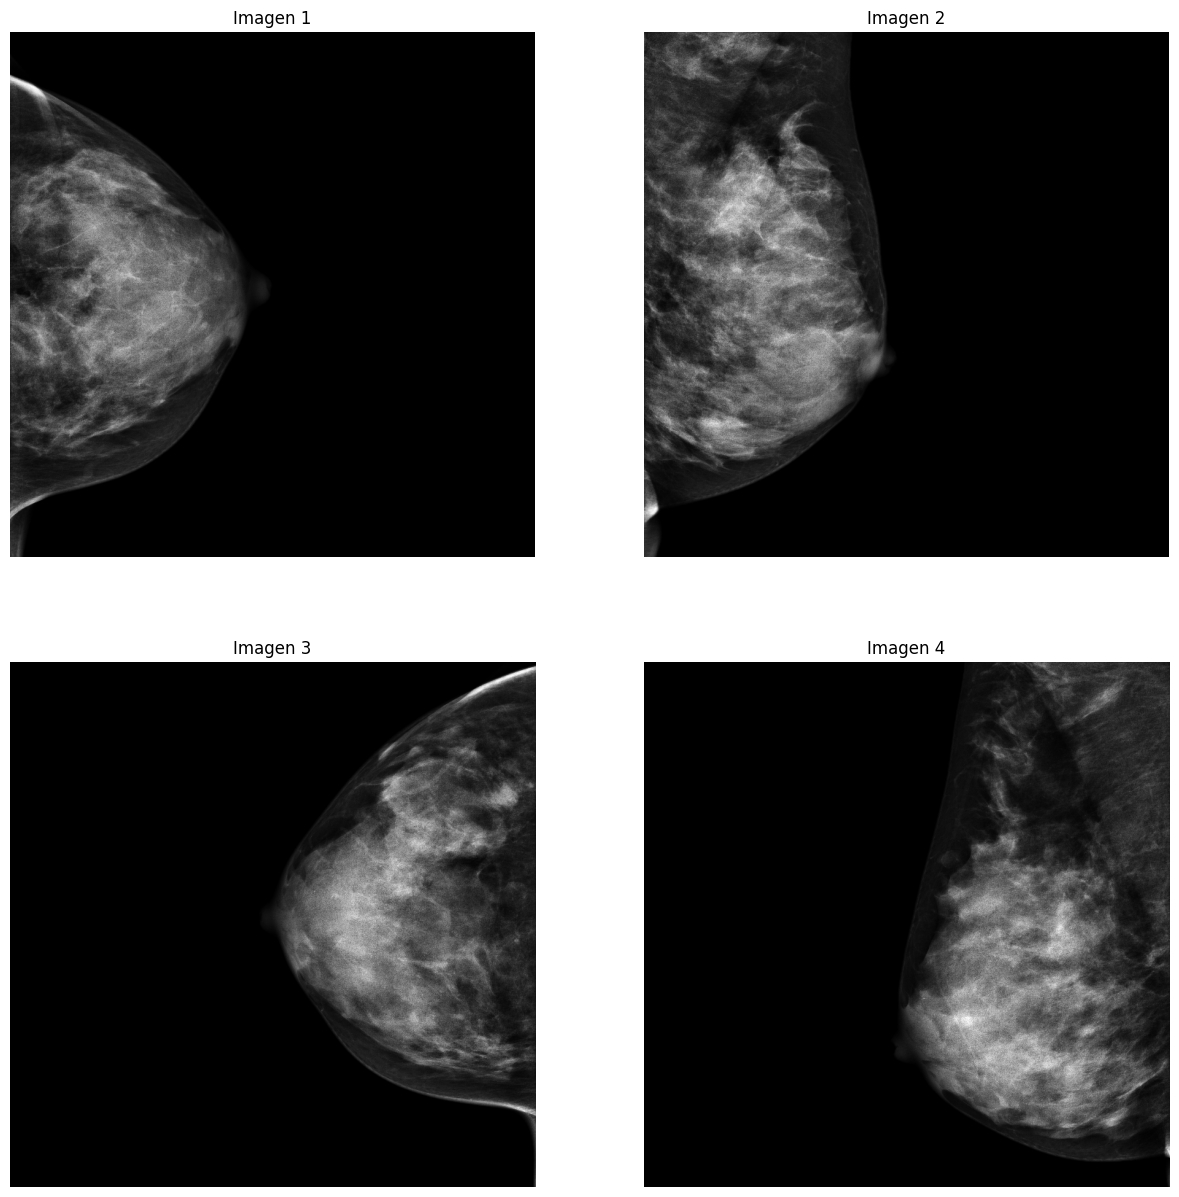

In [12]:
from matplotlib import pyplot as plt
img_array = np.load('E:/Numpys/Array/Solo_Benign_Malignant/Division/Training/Malignant/D2-0587.npy')

plt.figure(figsize=(15, 15))

for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(img_array[i], cmap='gray')
    plt.title(f'Imagen {i + 1}')
    plt.axis('off')

plt.show()